In [1]:
# Install required libraries (uncomment and run if not already installed)
# !pip install torch torch-geometric transformers pandas scikit-learn networkx

# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Transformer models
from transformers import AutoTokenizer, AutoModel

# Torch Geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class RecipeDirectionClassifier:
    def __init__(self, dataframe, test_size=0.2, random_state=42):
        """
        Initialize the classifier for recipe direction classification
        
        Parameters:
        -----------
        dataframe : pandas.DataFrame
            DataFrame with 'text' and 'classification' columns
        test_size : float, optional (default=0.2)
            Proportion of dataset to include in test split
        random_state : int, optional (default=42)
            Controls the shuffling applied to the data before splitting
        """
        # Ensure classification column is numeric
        dataframe['classification'] = dataframe['classification'].astype(float)
        
        # Split data
        self.train_texts, self.test_texts, self.train_labels, self.test_labels = train_test_split(
            dataframe['text'].values, 
            dataframe['classification'].values, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Load pre-trained model for embeddings
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.embedding_model = AutoModel.from_pretrained('bert-base-uncased')
        
        # Freeze embedding model parameters
        for param in self.embedding_model.parameters():
            param.requires_grad = False
    
    def get_text_embeddings(self, texts):
        """
        Generate embeddings for texts using BERT
        
        Parameters:
        -----------
        texts : list or numpy array
            List of text documents
        
        Returns:
        --------
        numpy.ndarray
            Embedded representations of texts
        """
        embeddings = []
        
        for text in texts:
            # Tokenize and get embeddings
            inputs = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
            
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)
                # Use mean pooling for text embedding
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            
            embeddings.append(embedding)
        
        # Convert list to numpy array for efficient tensor creation
        return np.array(embeddings)
    
    def create_text_graph(self, texts, labels):
        """
        Create a graph representation of text data
        
        Parameters:
        -----------
        texts : list or numpy array
            List of text documents
        labels : list or numpy array
            Corresponding labels for texts
        
        Returns:
        --------
        torch_geometric.data.Data
            Graph data object for training
        """
        # Get text embeddings
        embeddings = self.get_text_embeddings(texts)
        
        # Create graph
        G = nx.Graph()
        
        # Add nodes with embeddings and labels
        for i in range(len(embeddings)):
            G.add_node(i, embedding=embeddings[i], label=labels[i])
        
        # Connect nodes based on embedding similarity
        for i in range(len(embeddings)):
            for j in range(i+1, len(embeddings)):
                similarity = self.cosine_similarity(embeddings[i], embeddings[j])
                if similarity > 0.7:  # Adjust threshold as needed
                    G.add_edge(i, j, weight=similarity)
        
        # Prepare tensors
        if len(G.nodes) == 0:
            # Fallback if no graph is created
            x = torch.tensor(embeddings, dtype=torch.float32)
            edge_index = torch.empty((2, 0), dtype=torch.long)
            y = torch.tensor(labels, dtype=torch.float32)
        else:
            # Efficiently create node embeddings tensor
            node_embeddings = np.array([G.nodes[n]['embedding'] for n in G.nodes])
            x = torch.tensor(node_embeddings, dtype=torch.float32)
            
            # Convert edges to tensor
            edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.empty((2, 0), dtype=torch.long)
            
            # Create labels tensor
            y = torch.tensor([G.nodes[n]['label'] for n in G.nodes], dtype=torch.float32)
        
        return Data(x=x, edge_index=edge_index, y=y)
    
    def cosine_similarity(self, vec1, vec2):
        """
        Compute cosine similarity between two vectors
        
        Parameters:
        -----------
        vec1, vec2 : numpy.ndarray
            Input vectors
        
        Returns:
        --------
        float
            Cosine similarity between vectors
        """
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

class GraphTextClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Graph Convolutional Network for binary classification
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input features
        hidden_dim : int
            Dimension of hidden layer
        """
        super(GraphTextClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)  # Binary classification
    
    def forward(self, x, edge_index):
        """
        Forward pass through the graph neural network
        
        Parameters:
        -----------
        x : torch.Tensor
            Node features
        edge_index : torch.Tensor
            Graph connectivity
        
        Returns:
        --------
        torch.Tensor
            Predicted binary class probabilities
        """
        # Handle case where edge_index might be empty
        if edge_index.numel() == 0:
            # If no edges, use simple linear transformation
            x = self.conv1(x, edge_index)
            x = self.conv2(x, edge_index)
        else:
            x = self.conv1(x, edge_index).relu()
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index)
        
        return torch.sigmoid(x)

def train_graph_classifier(classifier, verbose=True):
    """
    Train the graph neural network classifier
    
    Parameters:
    -----------
    classifier : RecipeDirectionClassifier
        Prepared classifier for training
    verbose : bool, optional
        Whether to print training progress
    
    Returns:
    --------
    tuple
        Trained model and training metrics
    """
    # Prepare graph data
    train_graph = classifier.create_text_graph(classifier.train_texts, classifier.train_labels)
    test_graph = classifier.create_text_graph(classifier.test_texts, classifier.test_labels)
    
    # Model hyperparameters
    input_dim = train_graph.x.shape[1]
    hidden_dim = 64
    
    # Initialize model
    model = GraphTextClassifier(input_dim, hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    model.train()
    best_accuracy = 0
    training_history = {'loss': [], 'accuracy': []}
    
    for epoch in range(100):
        optimizer.zero_grad()
        
        # Handle potential shape differences
        out = model(train_graph.x, train_graph.edge_index).squeeze()
        
        # Ensure out and train_graph.y have compatible shapes
        if out.shape != train_graph.y.shape:
            out = out[:train_graph.y.shape[0]]
        
        loss = F.binary_cross_entropy(out, train_graph.y)
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_out = model(test_graph.x, test_graph.edge_index).squeeze()
            
            # Ensure test_out and test_graph.y have compatible shapes
            if test_out.shape != test_graph.y.shape:
                test_out = test_out[:test_graph.y.shape[0]]
            
            test_pred = (test_out > 0.5).float()
            accuracy = (test_pred == test_graph.y).float().mean()
            
            # Track training history
            training_history['loss'].append(loss.item())
            training_history['accuracy'].append(accuracy.item())
            
            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model.state_dict().copy()
        
        # Verbose output
        if verbose and (epoch % 10 == 0):
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {accuracy.item():.4f}")
    
    # Restore best model
    model.load_state_dict(best_model)
    
    return model, {
        'train_loss': loss.item(),
        'test_accuracy': best_accuracy.item(),
        'training_history': training_history
    }

# Visualization function (optional, requires matplotlib)
def plot_training_history(metrics):
    """
    Plot training loss and accuracy
    
    Parameters:
    -----------
    metrics : dict
        Training metrics dictionary
    """
    
    history = metrics['training_history']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

# Example usage in notebook
def main(df):
    # Sample DataFrame with recipe directions
    # Print initial dataset
    print("Dataset Overview:")
    print(df)
    print("\nDataset Shape:", df.shape)
    
    # Create classifier
    recipe_classifier = RecipeDirectionClassifier(df)
    
    # Train classifier
    model, metrics = train_graph_classifier(recipe_classifier)
    
    # Print metrics
    print("\nTraining Metrics:")
    print(f"Train Loss: {metrics['train_loss']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    
    # Optional: Plot training history
    try:
        plot_training_history(metrics)
    except ImportError:
        print("Matplotlib not available for plotting")
    
    return model, metrics

# If running in Jupyter, you can simply call main()
# model, metrics = main()

In [32]:
data = pd.read_csv('data/both_likes_dislikes.csv')
data = data[['directions', 'like_or_dislike']]

data = data.rename(columns={'directions':'text', 'like_or_dislike':'classification'})

Dataset Overview:
                                                 text  classification
0   ['Heat a large skillet over medium-high heat. ...               1
1   ['Preheat the oven to 350 degrees F (175 degre...               0
2   ['Preheat the oven to 350 degrees F (175 degre...               1
3   ['Place a paper towel on a microwave-safe plat...               1
4   ['Preheat the oven to 350 degrees F (175 degre...               1
5   ['Preheat oven to 400 degrees F (200 degrees C...               1
6   ['Dissolve salt in warm water, and mix in 1 cu...               0
7   ['Heat 2 tablespoons of olive oil in a large p...               1
8   ['Preheat oven to 375 degrees F (190 degrees C...               1
9   ["Set oven rack about 6 inches from the heat s...               1
10  ['Preheat oven to 400 degrees F (200 degrees C...               1
11  ['Mix chili powder, cumin, paprika, oregano, p...               1

Dataset Shape: (12, 2)
Loading BERT model and tokenizer...
Epoch 0: Los

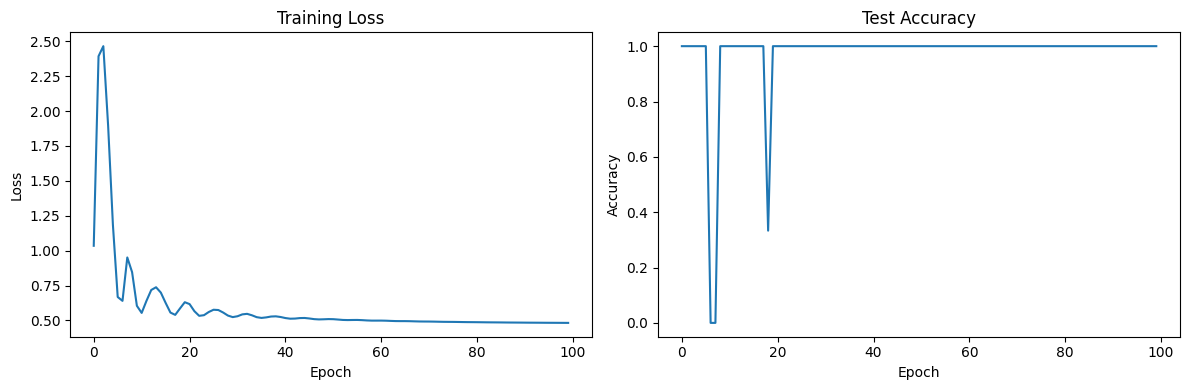

In [33]:
model, metrics = main(data)

## next

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# [Previous code remains the same as in the original script]

class RecipeDirectionClassifier:
    def __init__(self, dataframe, test_size=0.2, random_state=42):
        """
        Initialize the classifier for recipe direction classification
        
        Parameters:
        -----------
        dataframe : pandas.DataFrame
            DataFrame with 'text' and 'classification' columns
        test_size : float, optional (default=0.2)
            Proportion of dataset to include in test split
        random_state : int, optional (default=42)
            Controls the shuffling applied to the data before splitting
        """
        # Ensure classification column is numeric
        dataframe['classification'] = dataframe['classification'].astype(float)
        
        # Split data
        self.train_texts, self.test_texts, self.train_labels, self.test_labels = train_test_split(
            dataframe['text'].values, 
            dataframe['classification'].values, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Load pre-trained model for embeddings
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.embedding_model = AutoModel.from_pretrained('bert-base-uncased')
        
        # Freeze embedding model parameters
        for param in self.embedding_model.parameters():
            param.requires_grad = False
        
        # Store the trained graph neural network model
        self.graph_model = None
    
    # [Previous methods remain the same]
    
    def predict(self, texts, trained_model=None):
        """
        Predict classifications for new text samples
        
        Parameters:
        -----------
        texts : list or numpy array
            List of text documents to classify
        trained_model : torch.nn.Module, optional
            Trained graph neural network model (if not provided, uses self.graph_model)
        
        Returns:
        --------
        numpy.ndarray
            Predicted probabilities for each text sample
        """
        if trained_model is None:
            if self.graph_model is None:
                raise ValueError("No trained model available. Train the model first.")
            trained_model = self.graph_model
        
        # Ensure the model is in evaluation mode
        trained_model.eval()
        
        # Create a graph from the input texts
        predict_graph = self.create_text_graph(texts, np.zeros(len(texts)))
        
        # Disable gradient computation
        with torch.no_grad():
            # Get predictions
            predictions = trained_model(predict_graph.x, predict_graph.edge_index).numpy()
        
        # Return probabilities
        return predictions.flatten()
    
    def train_and_save_model(self, verbose=True):
        """
        Train the graph classifier and save the model
        
        Parameters:
        -----------
        verbose : bool, optional
            Whether to print training progress
        
        Returns:
        --------
        dict
            Training metrics
        """
        # Train the model
        self.graph_model, metrics = train_graph_classifier(self, verbose)
        
        return metrics

# Modify main function to demonstrate prediction
def main(df):
    # Sample DataFrame with recipe directions
    print("Dataset Overview:")
    print(df)
    print("\nDataset Shape:", df.shape)
    
    # Create classifier
    recipe_classifier = RecipeDirectionClassifier(df)
    
    # Train and save the model
    metrics = recipe_classifier.train_and_save_model()
    
    # Print metrics
    print("\nTraining Metrics:")
    print(f"Train Loss: {metrics['train_loss']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    
    # Example prediction
    example_texts = [
        "Preheat the oven and mix ingredients carefully",
        "Chop vegetables into small, uniform pieces",
        "Stir continuously to prevent burning"
    ]
    
    # Make predictions
    predictions = recipe_classifier.predict(example_texts)
    
    print("\nPrediction Examples:")
    for text, pred in zip(example_texts, predictions):
        print(f"Text: {text}")
        print(f"Probability of Class 1: {pred:.4f}")
        print(f"Predicted Class: {'1' if pred > 0.5 else '0'}\n")
    
    # Optional: Plot training history
    try:
        plot_training_history(metrics)
    except ImportError:
        print("Matplotlib not available for plotting")
    
    return recipe_classifier, metrics

# Note: In a Jupyter notebook, you would call this with your DataFrame
# classifier, metrics = main(your_dataframe)

# Add a convenience method for easy prediction threshold adjustment
def adjust_prediction_threshold(predictions, threshold=0.5):
    """
    Adjust predictions based on a custom threshold
    
    Parameters:
    -----------
    predictions : numpy.ndarray
        Predicted probabilities
    threshold : float, optional (default=0.5)
        Threshold for binary classification
    
    Returns:
    --------
    numpy.ndarray
        Binary predictions
    """
    return (predictions > threshold).astype(int)

In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# [Previous code remains the same as in the original script]

def visualize_text_network(classifier, graph_data, title='Text Similarity Network'):
    """
    Visualize the text similarity network
    
    Parameters:
    -----------
    classifier : RecipeDirectionClassifier
        The classifier used to create the graph
    graph_data : torch_geometric.data.Data
        Graph data object
    title : str, optional
        Title of the visualization
    """
    # Convert graph data to NetworkX
    G = nx.Graph()
    
    # Add nodes with their embeddings and labels
    for i in range(graph_data.x.shape[0]):
        node_embedding = graph_data.x[i].numpy()
        node_label = graph_data.y[i].item()
        G.add_node(i, embedding=node_embedding, label=node_label)
    
    # Add edges
    if graph_data.edge_index.numel() > 0:
        edges = graph_data.edge_index.t().numpy()
        for edge in edges:
            G.add_edge(edge[0], edge[1])
    
    # Prepare visualization
    plt.figure(figsize=(12, 8))
    
    # Use spring layout for node positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Color nodes based on their label
    node_colors = [('red' if G.nodes[node]['label'] == 1 else 'blue') for node in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    
    # Add title and labels
    plt.title(title)
    plt.axis('off')
    
    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', marker='o', linestyle='None', 
               markersize=10, label='Class 1'),
        Line2D([0], [0], color='blue', marker='o', linestyle='None', 
               markersize=10, label='Class 0')
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.show()

# Modify main function to include network visualization
def main(df):
    # Sample DataFrame with recipe directions
    # Print initial dataset
    print("Dataset Overview:")
    print(df)
    print("\nDataset Shape:", df.shape)
    
    # Create classifier
    recipe_classifier = RecipeDirectionClassifier(df)
    
    # Create graph data
    #train_graph = recipe_classifier.create_text_graph(recipe_classifier.train_texts, recipe_classifier.train_labels)
    
    # Visualize the network
    #visualize_text_network(recipe_classifier, train_graph, title='Recipe Direction Similarity Network')
    
    # Train classifier
    model, metrics = train_graph_classifier(recipe_classifier)
    
    # Print metrics
    print("\nTraining Metrics:")
    print(f"Train Loss: {metrics['train_loss']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    
    # Optional: Plot training history
    try:
        plot_training_history(metrics)
    except ImportError:
        print("Matplotlib not available for plotting")
    
    return model, metrics

In [37]:
main(data)

Dataset Overview:
                                                 text  classification
0   ['Heat a large skillet over medium-high heat. ...             1.0
1   ['Preheat the oven to 350 degrees F (175 degre...             0.0
2   ['Preheat the oven to 350 degrees F (175 degre...             1.0
3   ['Place a paper towel on a microwave-safe plat...             1.0
4   ['Preheat the oven to 350 degrees F (175 degre...             1.0
5   ['Preheat oven to 400 degrees F (200 degrees C...             1.0
6   ['Dissolve salt in warm water, and mix in 1 cu...             0.0
7   ['Heat 2 tablespoons of olive oil in a large p...             1.0
8   ['Preheat oven to 375 degrees F (190 degrees C...             1.0
9   ["Set oven rack about 6 inches from the heat s...             1.0
10  ['Preheat oven to 400 degrees F (200 degrees C...             1.0
11  ['Mix chili powder, cumin, paprika, oregano, p...             1.0

Dataset Shape: (12, 2)
Loading BERT model and tokenizer...


AttributeError: 'RecipeDirectionClassifier' object has no attribute 'create_text_graph'

In [ ]:
model, classifier = main(data)